<a href="https://colab.research.google.com/github/jeovafarias/SAR-Roughness-Estimation-Neural-Nets/blob/main/Roughness_Map_SAR_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [681]:
import numpy as np
import time
import os
from PIL import Image

import torch
import torch.nn as nn
from google.colab import drive
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import sys

from io import BytesIO
from PIL import Image
import requests

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

def sample_gi0(alpha,gamma,L,sample_size=10):
  """
  Sample from gi0 distribution: Z=X/Y'
  Inputs: alpha<0, gamma>0, L=1,3,8;
  Outputs: random samples of the given sample size
  Using the SAR textbook Gamma notations:
  X follows Gamma(1,L);
  Y' follows Gamma(-alpha,gamma)
  """
  xx = stats.gamma.rvs(a=L, scale=1/L, size=sample_size)
  yy = stats.gamma.rvs(a=gamma, scale=-alpha/gamma, size=sample_size)
  zz = xx/yy
  return zz

We are using the following device for learning: cuda


In [682]:
!nvidia-smi

Tue Jun  6 19:10:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    27W /  70W |   1495MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Parameters

In [683]:
L = 1
img_size = (10, 10)
ds_size = 1000 
num_moments = 2
batch_size = 32
n_epochs = 300
alphas = np.arange(-1.5, -15.5, -0.5, dtype=float)

kernel_sizes = np.arange(3, 11, 2, dtype=int).astype(int)

## Generate Data

In [684]:
def generate_training_data(num_moments, ds_size, alphas, L, kernel_sizes, img_size):
    (w, h) = img_size
    x_train = torch.zeros((ds_size, num_moments, w, h))
    y_train = torch.zeros((ds_size, 1, w, h))
    for i in range(ds_size):
        alpha = np.random.choice(alphas)
        gamma = - alpha + 1
        kernel_size = np.random.choice(kernel_sizes)
        m = nn.AvgPool2d(kernel_size, stride=1)

        target = alpha * torch.ones(img_size)[None, None, :]
        new_w = w + kernel_size - 1
        new_h = h + kernel_size - 1
        # print(f"{kernel_size} - ({w}, {h}) - ({new_w}, {new_h})")

        samples = sample_gi0(alpha, gamma, L,sample_size = new_w * new_h)
        img = torch.Tensor(samples.reshape((new_w, new_h)))[None, :]

        log_imgs = [torch.pow(torch.log(img), j) for j in range(1, num_moments+1)]
        ave_log_imgs = torch.stack([m(log_img) for log_img in log_imgs], 1)

        x_train[i] = ave_log_imgs
        y_train[i] = target

    return x_train, y_train

x_train, y_train = generate_training_data(num_moments, ds_size, alphas, L, kernel_sizes, img_size)

print(x_train.shape)
print(y_train.shape)

torch.Size([1000, 2, 10, 10])
torch.Size([1000, 1, 10, 10])


## Auxiliary Functions

In [685]:
def get_moments_input(img, w, num_moments):
    m = nn.AvgPool2d(w, stride=1, padding=(int(w/2), int(w/2)))

    img = torch.Tensor(img)
    log_imgs = [torch.pow(torch.log(img), j) for j in range(1, num_moments+1)]
    ave_moment_imgs = torch.stack([m(j) for j in log_imgs], 1)

    return ave_moment_imgs

def generate_test_input(alpha, w, L, img_size=(200, 200), num_moments=2):
    gamma = - alpha + 1
    samples = sample_gi0(alpha, gamma, L, sample_size = img_size[0]*img_size[1])
    img = torch.Tensor(samples.reshape(img_size))[None, :]

    logs = get_moments_input(img, w, num_moments)

    return logs

# Network / Dataset Settings and Training

In [686]:
from torch.utils.data import Dataset, DataLoader

class SARDataset(Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x = self.x[ix]
        y = self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

dataset = SARDataset(x_train, y_train)
dl = DataLoader(dataset, batch_size, shuffle=True)

In [687]:
class NeuralNet(nn.Module):
    def __init__(self, num_moments = 2):
        super().__init__()  
        self.conv1 = nn.Conv2d(num_moments, 8, kernel_size=1)
        self.conv2 = nn.Conv2d(8, 4, kernel_size=1)
        self.conv3 = nn.Conv2d(4, 1, kernel_size=1)
        self.AC1 = nn.Tanh()
        self.AC2 = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.AC1(x)
        x = self.conv2(x)
        x = self.AC2(x)

        x = self.conv3(x)
        return x

model = NeuralNet(num_moments).to(device)

In [688]:
from torch.optim import Adam

loss_fn = nn.MSELoss(reduction='mean')
optimizer = Adam(model.parameters(), lr=1e-3)

In [689]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    
    batch_loss = loss_fn(model(x), y)  # Compute loss
    batch_loss.backward()              # Compute gradients
    opt.step()                         # Make a GD step
    opt.zero_grad()                    # Flush memory  

    return batch_loss.detach().cpu().numpy()

In [690]:
t = time.time()
losses, errors = [], []
for epoch in range(n_epochs):
    if epoch % 30 == 0:
        print(f"Running epoch {epoch + 1} of {n_epochs}")
    
    epoch_losses = []
    for batch in dl:
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    losses.append(np.mean(epoch_losses))

    # errors.append(error(data, target, model))
print(f"- {time.time() - t} seconds")

Running epoch 1 of 300
Running epoch 31 of 300
Running epoch 61 of 300
Running epoch 91 of 300
Running epoch 121 of 300
Running epoch 151 of 300
Running epoch 181 of 300
Running epoch 211 of 300
Running epoch 241 of 300
Running epoch 271 of 300
- 26.6917405128479 seconds


# Results

Final loss: 2.4239370822906494


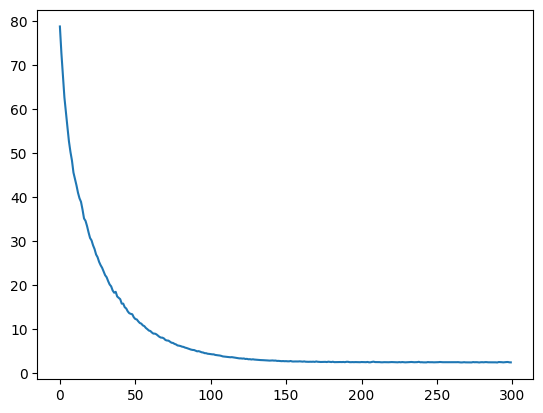

In [691]:
#@title Error plot
plt.plot(losses)
print(f'Final loss: {losses[-1]}')

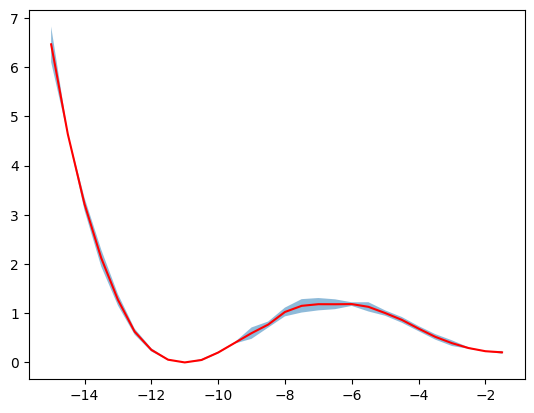

- 0.9116804599761963 seconds


In [692]:
#@title Error over different alphas
t = time.time()

model.eval()
kernel_size = 3
num_trials = 3

alphas = np.arange(-1.5, -15.5, -0.5, dtype=float)
mses = np.zeros((num_trials, len(alphas)))
for i in range(num_trials):
  for j, alpha in enumerate(alphas):
    input = generate_test_input(alpha, kernel_size, L,  num_moments=num_moments).to(device)
    pred = model(input)

    ave_alpha = torch.mean(pred).detach().cpu().numpy()
    mses[i, j] = (alpha-ave_alpha)**2

mean_mse = np.mean(mses, axis=0)
mean_std = np.std(mses, axis=0)
plt.fill_between(alphas, mean_mse-2*mean_std, mean_mse+2*mean_std, alpha=0.5)
plt.plot(alphas, mean_mse, "r")
plt.show()

print(f"- {time.time() - t} seconds")

Expected alpha: -15
Average prediction: -12.446880340576172 +/- 1.7122621536254883
Predictions:


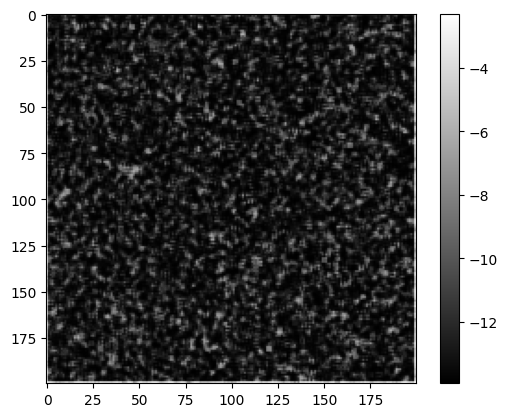

In [693]:
#@title Prediction on synthetic image
sample_size = 3
alpha = -15

input = generate_test_input(alpha, sample_size, L, num_moments=num_moments)
pred = model(input.to(device))

print(f'Expected alpha: {alpha}')
print(f'Average prediction: {torch.mean(pred).detach().cpu().numpy()} +/- {torch.std(pred)}')

print("Predictions:")
img_pred = pred.detach().cpu().numpy()
plt.imshow(img_pred[0, 0, :, :], cmap="gray")
plt.colorbar()
plt.show()

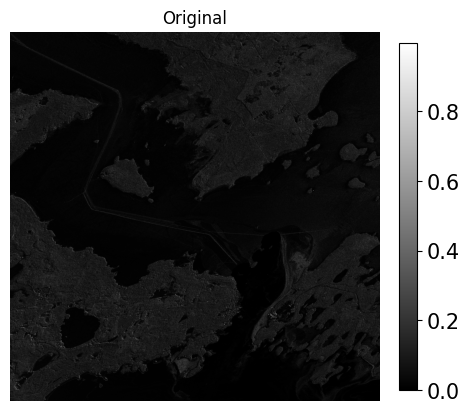

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Time for kernel size 3: 0.15079808235168457


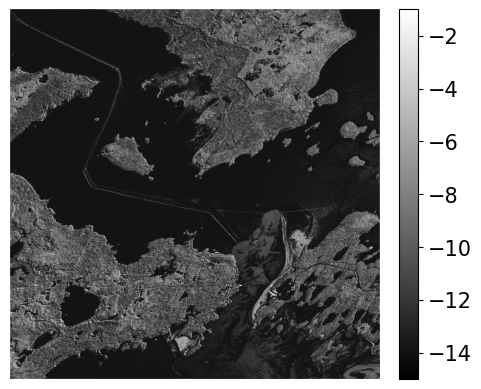

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Time for kernel size 11: 0.6077957153320312


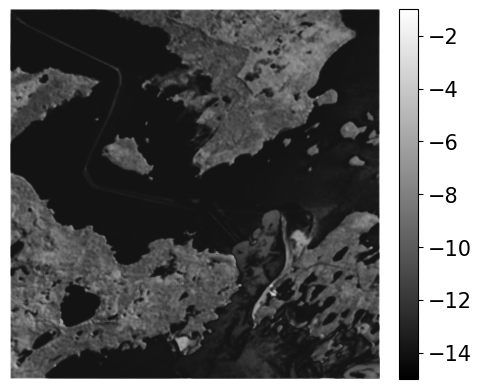

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Time for kernel size 20: 2.2061095237731934


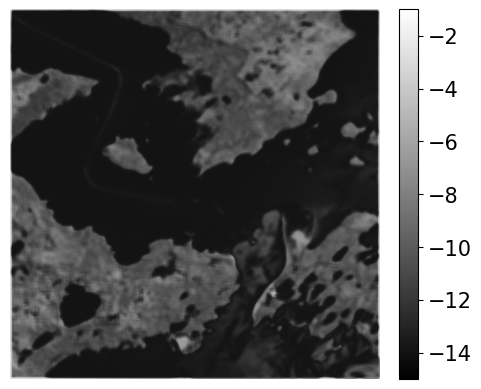

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Time for kernel size 45: 11.665529489517212


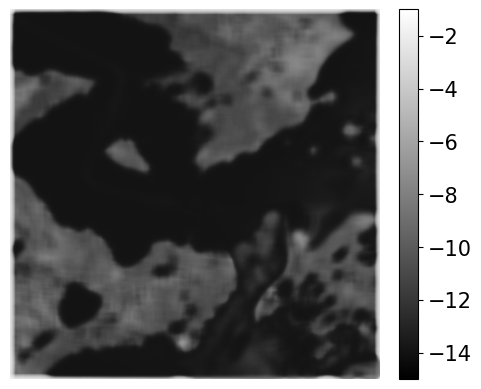

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [706]:
#@title Real Images
from google.colab import files

assert L == 1 or L == 4, "The available image are on 1 look"
model.eval()

kernel_sizes = [3, 11, 20, 45]

url = 'https://github.com/jeovafarias/SAR-Roughness-Estimation-Neural-Nets/raw/main/imgs/ImgSSM_c_IntHH_1500x1500.tif'
img_txt = requests.get(url).content
img = np.array(Image.open(BytesIO(img_txt))).astype(float)
img_tensor = torch.Tensor(img)[None, :]

img_new = img.copy()
img_new[img_new > 1] = 0
plt.imshow(img_new, "gray")
plt.title("Original")
cb = plt.colorbar(fraction=0.035, pad=0.04)
cb.ax.tick_params(labelsize=15)
plt.axis('off')
plt.show()

plt.imsave('original.png', pred, cmap="gray", vmin=0, vmax=1)
files.download('original.png')

for kernel_size in kernel_sizes:
  t = time.time()
  logs = get_moments_input(img_tensor, kernel_size, num_moments)
  pred = model(logs.to(device))
  print(f'Time for kernel size {kernel_size}: {time.time() - t}')

  pred = pred[0, 0, :, :].cpu().detach().numpy()
  plt.imshow(pred, "gray", vmin=-15, vmax=-1)
  cb = plt.colorbar(fraction=0.04, pad=0.04)
  cb.ax.tick_params(labelsize=15)
  plt.axis('off')
  plt.show()

  plt.imsave(f'result_k{kernel_size}.png', pred, cmap="gray", vmin=-15, vmax=-1)
  files.download(f'result_k{kernel_size}.png')

In [705]:
ig1 = plt.gcf()
plt.savefig(f'result_k{kernel_size}_colorbar.png', dpi=100)
files.download(f'result_k{kernel_size}_colorbar.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [696]:
# from PIL import Image
# import glob

# drive.mount('/content/drive')
# root_path = '/content/drive/MyDrive/cs thesis - Li Fan/results'
# data_path = root_path+'/mse_new/imgs/Sault Sainte Marie'

# # model.load_state_dict(torch.load(model_path))
# model.eval()

# dirs = glob.glob(f'{data_path}/*.tif')

# window_size = 3

# for file in dirs[0:1]:
#   img = np.array(Image.open(file)).astype(float)
#   # img[img > 1] = 0
#   img = img[1500:3000, 1050:2550]
#   print(img.shape)

#   im = Image.fromarray(img)
#   im.save(data_path + '_test.tif')
#   files.download(data_path + '_test.tif')
  
#   img_pre_tensor = img
#   img_tensor = torch.Tensor(img_pre_tensor)[None, :]

#   t = time.time()
#   logs = get_moments_input(img_tensor, window_size, num_moments)
#   pred = model(logs.to(device))
#   print(time.time() - t)
#   print(file)

#   img_new = img.copy()
#   img_new[img_new > 1] = 0
#   plt.imshow(img_new, "gray")
#   plt.colorbar(fraction=0.035, pad=0.04)
#   plt.axis('off')
#   plt.imsave(f"/{os.path.splitext(file)[0]}.png", img, cmap="gray")
#   plt.show()

#   pred = pred[0, 0, :, :].cpu().detach().numpy()
#   # plt.imshow(pred, "gray")
#   plt.imshow(pred, "gray", vmin=-15, vmax=0)
#   plt.colorbar(fraction=0.04, pad=0.04)
#   plt.axis('off')
#   plt.imsave( f"/{os.path.splitext(file)[0]}.png", pred, cmap="gray")
#   plt.savefig(f"/{os.path.splitext(file)[0]}_fig.png")
#   plt.show()

In [697]:
import os
import sys
from google.colab import drive

model.eval()

real_img_size = (450, 600)
window_size = 3
drive.mount('/content/drive
root_path = '/content/drive/MyDrive/cs thesis - Li Fan/results'
data_path = root_path+'/mse_new/imgs/San Francisco'

# model_path = root_path+'/mse_new/model_1_L4.pth'
# model.load_state_dict(torch.load(model_path))

dirs = os.listdir(data_path)
i = 0
for file in dirs:
   img = np.reshape(np.genfromtxt(data_path + "/" + file), real_img_size).astype(float)
   img_3 = img
   img_tensor = torch.Tensor(img)[None, :]
   print(np.sum(img > 1))
   img[img > 1] = 0

   t = time.time()
   logs = get_moments_input(img_tensor, window_size, num_moments=2)
   pred = model(logs.to(device))
   et = time.time() - t
   print(et)
   print(file)


  #  img_rescaled = 255*(img - np.min(img))/(np.max(img) - np.min(img))
   plt.imshow(img, "gray")
   plt.colorbar(fraction=0.035, pad=0.04)
   plt.axis('off')
   plt.imsave(data_path + f"/Img_SF{i}.png", img, cmap="gray")
   plt.show()

   pred = pred[0, 0, :, :].cpu().detach().numpy()
   plt.imshow(pred, "gray")
   plt.colorbar(fraction=0.035, pad=0.04)
   plt.axis('off')
   plt.imsave(data_path + f"/Img_SF_pred{i}.png", pred, cmap="gray")
   plt.savefig(data_path + f"/Img_SF_pred{i}_fig.png")
   i = i + 1
   plt.show()


SyntaxError: ignored

In [ ]:
print(np.linalg.norm(img_2 - img_3))

a = img_2 == img_3
plt.imshow(a)